In [1]:
#IMPUTATION AND NORMALIZATION OF ORIGINAL 2017 DATASET
#Import libraries as needed
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
#Import single csv file to dataframe
df = pd.read_csv ('clean_sample.csv', delimiter =',')

In [ ]:
print(df.info())

In [3]:
#STEP 1: IMPUTE DATA 

df['date'] = pd.to_datetime(df['date'])

# Set the 'date' column as the index of the DataFrame
df = df.set_index('date')

# Interpolate missing values using time-based interpolation
df= df.interpolate(method='time',limit_direction='both')

# Reset the index to use an integer index instead of 'date'
df = df.reset_index(drop=False)

In [4]:
#Step 2: ADD AQI Columns
# Define the breakpoints and categories
breakpoints = {
    'PM25': [0, 10, 20, 25, 50, 75, 800],
    'PM10': [0, 20, 40, 50, 100, 150, 1200],
    'NO_2': [0, 40, 90, 120, 230, 340, 1000],
    'O_3': [0, 50, 100, 130, 240, 380, 800],
    'SO_2': [0, 100, 200, 350, 500, 750, 1250]
}

categories = ['Good', 'Fair', 'Moderate', 'Poor', 'Very Poor', 'Extremely Poor']

In [5]:
# Define a function to calculate the AQI index for a given pollutant and concentration
def calculate_index_level(pollutant, concentration):
    breakpoints_list = breakpoints[pollutant]
    for i in range(len(breakpoints_list)-1):
        if breakpoints_list[i] <= concentration < breakpoints_list[i+1]:
            return i+1
    return 6  # If concentration exceeds the highest breakpoint, return the highest index level

In [6]:
# Define a function to calculate the overall AQI index for a row of data
def calculate_aqi_index(row):
    levels = [calculate_index_level('PM25', row['PM25']),
              calculate_index_level('PM10', row['PM10']),
              calculate_index_level('NO_2', row['NO_2']),
              calculate_index_level('O_3', row['O_3']),
              calculate_index_level('SO_2', row['SO_2'])]
    return max(levels)

In [7]:
# Calculate the AQI index for each row
df['AQI_Index'] = df.apply(calculate_aqi_index, axis=1)

In [8]:
# Define a function to calculate the AQI category for a given index level
def calculate_aqi_category(index_level):
    return categories[index_level-1]

# Add a column for the AQI category
df['AQI_Category'] = df['AQI_Index'].apply(calculate_aqi_category)

In [9]:
# Define 2 categories for general population: Safe or Hazardous
safety_2_categories = {1: 'Safe', 2: 'Safe', 3: 'Safe', 4: 'Hazardous', 5: 'Hazardous', 6: 'Hazardous'}

# Map the categories for the general Population to the AQI_Index values and create the new column
df['AQI_GenPop'] = df['AQI_Index'].map(safety_2_categories)

In [10]:
# create a dictionary to map categories to corresponding indices
category2_map = {'Safe': 0, 'Hazardous': 1}

# add a new column 'AQI_GenPop_Index' based on the 'AQI_GenPop' column
df['AQI_GenPop_Index'] = df['AQI_GenPop'].map(category2_map)

In [11]:
#Define 3 AQI categories for sensitive groups
safety_3_categories = {1: 'Safe', 2: 'Safe', 3: 'Caution', 4: 'Caution', 5: 'Hazardous', 6: 'Hazardous'}

# Map the categories for the general Population to the AQI_Index values and create the new column
df['AQI_Sens_Pop'] = df['AQI_Index'].map(safety_3_categories)

In [12]:
# create a dictionary to map categories to corresponding indices
category3_map = {'Safe': 1, 'Caution':2, 'Hazardous': 3}

# add a new column 'AQI_GenPop_Index' based on the 'AQI_GenPop' column
df['AQI_SensPop_Index'] = df['AQI_Sens_Pop'].map(category3_map)

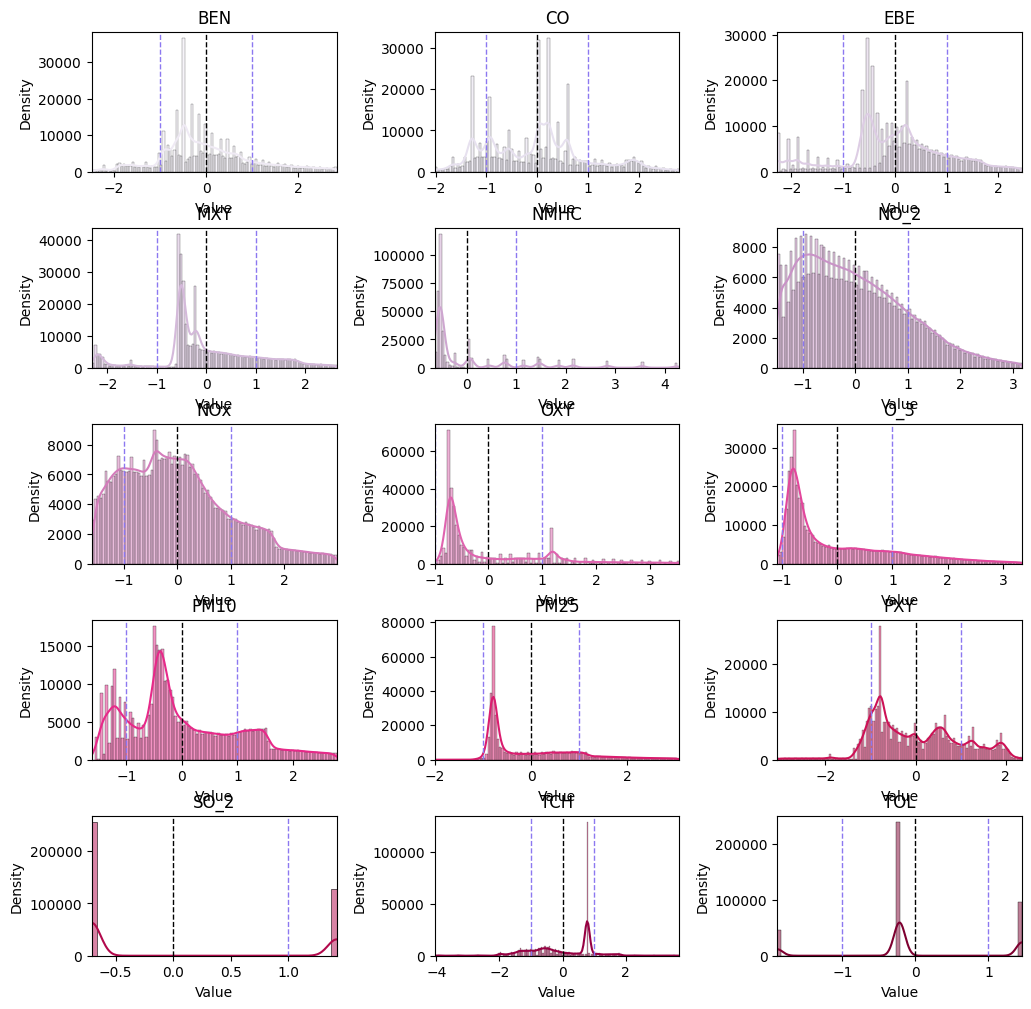

In [21]:
#VISUALIZE USING HISTOGRAMS / View Distributions 
# Get the columns to plot
#pollutants = df.columns[1:-1]
pollutants = df.columns[0:15] #for all year sample df

# Create a figure with 4x4 subplots
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(12, 12))

# Plot a histogram for each column
for i, pollutant in enumerate(pollutants):
    # Get the data for the column
    data = df[pollutant].dropna()
    
    # Determine the subplot location based on the column index
    row = i // 3
    col = i % 3
    # get the range of values in the column, ignoring NaN and Inf
    x_min = np.nanmin(df[pollutant][np.isfinite(df[pollutant])])
    x_max = np.nanmax(df[pollutant][np.isfinite(df[pollutant])])
    
    # calculate number of bins using IQR rule
    n = len(df[pollutant])
    std = np.std(df[pollutant])
    k = 3.5 * std / (n**(1/3))
    num_bins = int(np.ceil((x_max - x_min) / k)) if k != 0 else 1
    # Plot the histogram with kde
    sns.histplot(data, kde=True, bins=num_bins, color=sns.color_palette("PuRd", 15)[i], ax=axs[row, col])
    
    # Add a vertical line for the mean
    mean = data.mean()
    axs[row, col].axvline(mean, color='k', linestyle='dashed', linewidth=1)
    
    # Add a vertical line for the standard deviation
    std = data.std()
    axs[row, col].axvline(mean+std, color='#8C78F0', linestyle='dashed', linewidth=1)
    axs[row, col].axvline(mean-std, color='#8C78F0', linestyle='dashed', linewidth=1)
    
    # Set the title and axis labels
    axs[row, col].set_title(pollutant)
    axs[row, col].set_xlabel('Value')
    axs[row, col].set_ylabel('Density')
    axs[row, col].set_xlim([data.min(), data.max()])  # set x-axis range

# Adjust the spacing between subplots
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# Show the plot
plt.show()

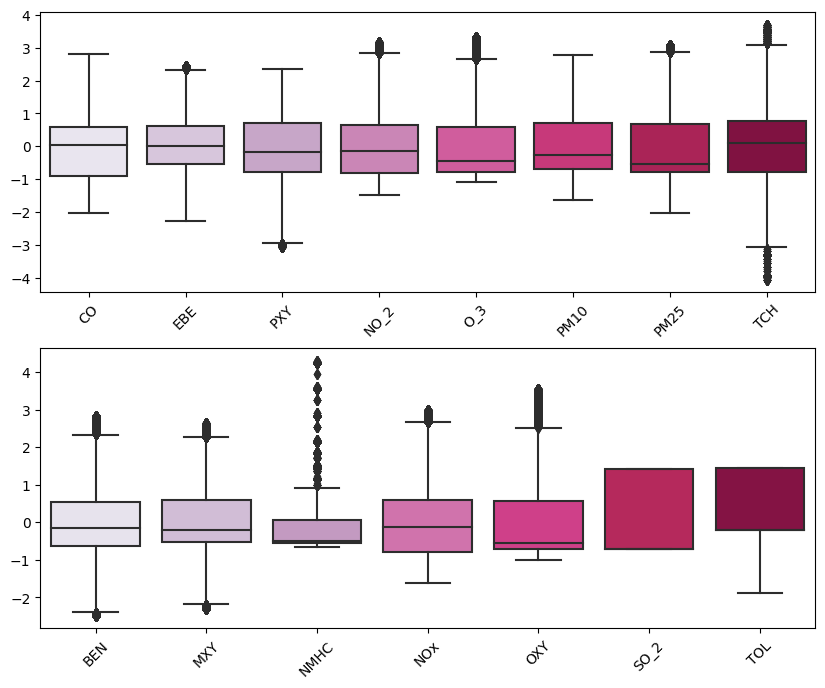

In [18]:
#STEP 3: DEAL WITH OUTLIERS/ NORMALIZE
df_top = df[['CO', 'EBE','PXY','NO_2', 'O_3', 'PM10', 'PM25','TCH']]
df_bottom = df[['BEN', 'MXY', 'NMHC', 'NOx', 'OXY', 'SO_2', 'TOL']]

fig, axs = plt.subplots(2, figsize=(10, 8))

# First plot with first 7 rows
sns.boxplot(data=df_top, palette='PuRd', ax=axs[0])
axs[0].set_xticklabels(df_top.columns, rotation=45)

# Second plot with last 7 rows
sns.boxplot(data=df_bottom, palette='PuRd', ax=axs[1])
axs[1].set_xticklabels(df_bottom.columns, rotation=45)

plt.show()

In [14]:
#3.1: IQR OUTLIER REMOVAL

# Get the columns to normalize
pollutants = df.columns[1:15]

# Find outliers using the IQR method with k=1.5
Q1 = df[pollutants].quantile(0.25)
Q3 = df[pollutants].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

#show number of outliers
outliers = (df[pollutants] < lower_bound) | (df[pollutants] > upper_bound)
print(outliers.sum())

#Remove outliers
df[pollutants] = df[pollutants].mask(outliers)

BEN     16966
CH4     51798
CO      13762
EBE     19953
NMHC     5935
NO      27420
NO_2     5160
NOx     52550
O_3       327
PM10     8603
PM25     8080
SO_2     5006
TCH     11358
TOL     17246
dtype: int64


In [15]:
# Fill NaN values using time-based interpolation
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')
df = df.interpolate(method='time', limit_direction='both')
df = df.reset_index(drop=False)

In [15]:
#3.2: Z-SCORE NORMALIZATION BETTER FOR BAYESIAN LOGISTIC REGRESSION

# Get the columns to normalize
pollutants = df.columns[0:15]

# Apply z-score normalization
df[pollutants] = (df[pollutants] - df[pollutants].mean()) / df[pollutants].std()


In [ ]:
df = df.drop(columns=['CH4', 'NOx']) #didn't normalize siga min katsw na skasw

In [ ]:
nan_counts = df.isnull().sum()
print(nan_counts)

In [ ]:
df.head(10)

In [ ]:
print(df.info())

In [ ]:
print(pollutants)

In [ ]:
# Save the DataFrame to a CSV file in the current working directory
df.to_csv('C:\\Users\\eleni\\Documents\\Diplw\\Jupyter-Notebooks\\diplw\\madris_2017_clean.csv', index=False)

In [22]:
# Save the DataFrame to a CSV file in the current working directory
df.to_csv('C:\\Users\\eleni\\Documents\\Diplw\\Jupyter-Notebooks\\diplw\\clean_sample_norm.csv', index=False)